In [1]:
import csv
import os
import time

%matplotlib inline
import matplotlib.pylab as pylab
import pandas as pd

pylab.rcParams['figure.figsize'] = 16, 8

In [2]:
def age_group_mapping(age):
    if age <= 9:
        return '0-9'
    elif (age >= 10) & (age <= 14):
        return '10-14'
    elif (age >= 15) & (age <= 17):
        return '15-17'
    elif (age >= 18) & (age <= 24):
        return '18-24'
    elif (age >= 25) & (age <= 29):
        return '25-29'
    elif (age >= 30) & (age <= 39):
        return '30-39'
    elif (age >= 40) & (age <= 49):
        return '40-49'
    elif (age >= 50) & (age <= 59):
        return '50-59'
    else:
        return '60+'

In [3]:
census_data_filepath = '/Users/ng/Downloads/age5racethsexcopop1980_2015.csv'
orig_population_df = pd.read_csv(census_data_filepath)
del orig_population_df['county']

In [4]:
orig_population_df.rename(columns={'poptot_': 'All Combined', 
                                   'popwhite_': 'White', 
                                   'pophisp_': 'Hispanic', 
                                   'popapi_': 'Asian/Pacific Islander', 
                                   'popblack_': 'Black', 
                                   'popamind_': 'Native American', 
                                   'popother_': 'Other', 
                                   'sex': 'gender', 
                                   'countyname': 'county',
                                  }, inplace=True)

In [5]:
orig_population_df['age_group'] = orig_population_df['age'].apply(lambda x: age_group_mapping(x))

In [6]:
# We want both age ranges (e.g., 0-9 and so on), but also want 'Juvenile' and 'Adult' labels.
juvenile_groups = ['0-9', '10-14', '15-17']
adult_groups = set(orig_population_df['age_group']) - set(juvenile_groups)

juveniles = orig_population_df[orig_population_df['age_group'].isin(juvenile_groups)].copy()
juveniles['age_group'] = 'Juvenile'

adults = orig_population_df[orig_population_df['age_group'].isin(adult_groups)].copy()
adults['age_group'] = 'Adult'

orig_population_df = pd.concat([orig_population_df, juveniles, adults])

In [7]:
races = ['Hispanic', 'Black', 'White', 'Asian/Pacific Islander', 'Other']
for race in races:
    orig_population_df[race] = orig_population_df[race].apply(lambda x: int(round(x)))

In [8]:
orig_population_df.head()

,county,year,gender,age,All Combined,White,Hispanic,Asian/Pacific Islander,Black,Other,fips,age_group
0,Alameda,1980,Male,0,8347.0,4241,1586,681,1792,47,1,0-9
1,Alameda,1980,Male,1,7553.0,3759,1419,629,1697,49,1,0-9
2,Alameda,1980,Male,2,7369.0,3610,1423,612,1677,47,1,0-9
3,Alameda,1980,Male,3,7096.0,3552,1298,595,1603,48,1,0-9
4,Alameda,1980,Male,4,7088.0,3434,1306,662,1649,37,1,0-9


In [9]:
start = time.time()
# columns in output data frame (for table in data oasis)
fieldnames = ['year', 'county', 'race', 'gender', 'age_group', 'population']
# columns to group by for aggregation
columns = ['year', 'county', 'gender', 'age_group']
county_year_sex_agegroup = orig_population_df.groupby(columns)
result = []
for group_name, data in county_year_sex_agegroup:
    for race in races:
        row = {}
        row['year'], row['county'], row['gender'], row['age_group'] = group_name
        row['race'] = race
        row['population'] = data[race].sum()
        result.append(row)
df = pd.DataFrame.from_dict(result)
df = df[fieldnames]
df_copy = df.copy()
stop = time.time()
print('Took {} seconds to complete.'.format(stop - start))

Took 60.733598947525024 seconds to complete.


In [10]:
# Columns to aggregate produce 'All Combined' results for County
start = time.time()
columns = ['county', 'race', 'gender', 'age_group']
by_year = df_copy.groupby(['year'])
result = []
for year, data in by_year:
    for column in columns:
        agg_columns = list(set(columns) - set([column]))
        rows = data.groupby(agg_columns)['population'].sum().reset_index()
        rows[column] = 'All Combined'
        rows['year'] = year
        rows = rows[fieldnames]
        data = pd.concat([data, rows])
    result.append(data)
df = pd.concat(result)
df = df.sort_values(by=fieldnames).reset_index(drop=True)

# Necessary because there a multiple (i.e. 2) levels of aggregation for age groups (age ranges and juvenile vs adult)
is_all_combined = df['age_group'] == 'All Combined'
df.loc[is_all_combined, 'population'] = df.loc[is_all_combined, 'population'] / 2
df['population'] = df['population'].astype(int)

output_file = '/Users/ng/Downloads/ca_county_population_by_race_gender_age_1980-2015_08-17-2016_ng.csv'
df.to_csv(output_file, index=False)
stop = time.time()
print('Took {} seconds to complete.'.format(stop - start))

Took 6.127923011779785 seconds to complete.


# Cells below here used for sanity checking

In [11]:
validation_filepath = '/Users/ng/Downloads/ca_county_population_by_race_gender_age_1980-2015_08-17-2016_sp.csv'
sp = pd.read_csv(validation_filepath)
sp = sp.sort_values(by=fieldnames).reset_index(drop=True)

In [12]:
# remove other from the processed data because the comparison dataset doesn't have the 'Other' race category.
df = df[df.race != 'Other']
df = df.sort_values(by=fieldnames).reset_index(drop=True)
# fin
df['wat'] = df.population != sp.population

In [13]:
sp['pop_diff'] = df[df['wat']]['population'].sub(sp[df['wat'].values]['population'])
# get an extreme example of population differences 
sp[sp.pop_diff == sp.pop_diff.min()]

,year,county,race,gender,age_group,population,pop_diff
297549,2008,All Combined,All Combined,All Combined,Adult,27330281,-321.0


In [14]:
ex_year = 2008
ex_agegroup = 'Adult'
# Example data subset for validating state population differences
d2008 = df_copy[df_copy['year'] == ex_year]
d2008 = d2008[d2008['age_group'] == ex_agegroup]
print('Total population {} using this notebook (sums over races instead of using the poptotal_ column)'.format(d2008.population.sum()))

Total population 27329960 using this notebook (sums over races instead of using the poptotal_ column)


In [15]:
# In theory, these should be equal, but are not due to small rounding errors.
orig_population_df['summed_total'] = orig_population_df[races].sum(axis=1)
orig_population_df['difference'] = orig_population_df['All Combined'].sub(orig_population_df['summed_total'])

In [16]:
o2008 = orig_population_df[orig_population_df['year'] == ex_year]
o2008 = o2008[o2008['age_group'] == ex_agegroup]
o2008['All Combined'].apply(lambda x: round(x)).sum()
print('Total population {} using old ppic notebook (uses poptotal_ column)'.format(o2008['All Combined'].apply(lambda x: round(x)).sum()))

Total population 27330281 using old ppic notebook (uses poptotal_ column)


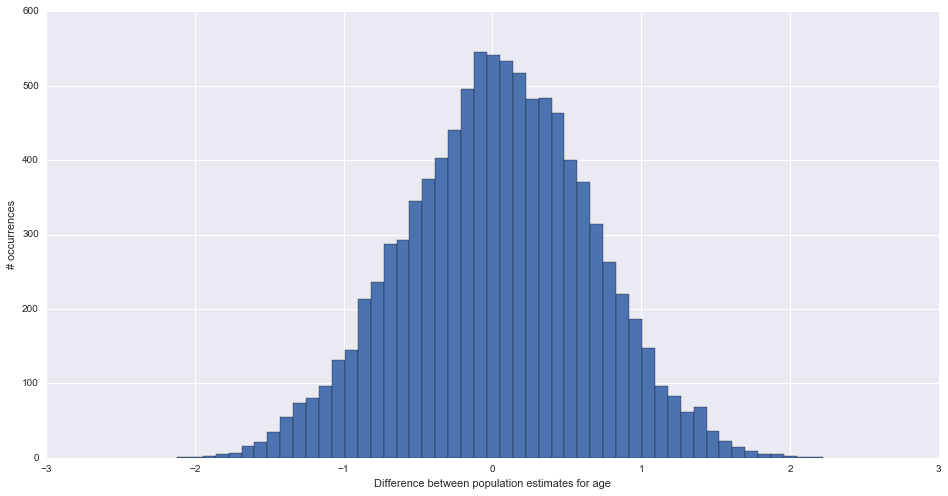

In [19]:
# plot the distribution of population differences.
fig = o2008['difference'].hist(bins=50)
fig.set_xlabel('Difference between population estimates for age')
fig.set_ylabel('# occurrences')